In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import multiprocessing

plt.style.use('ggplot')

import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from scipy.special import softmax

In [4]:
# load dataset
df = pd.read_csv('../data/raw/Reviews.csv')

### Data description

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [6]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [7]:
df['Text'].values[0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

### EDA

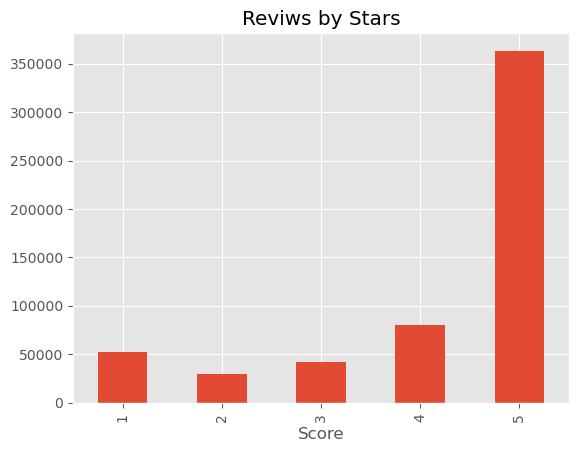

In [8]:
df['Score'].value_counts().sort_index().plot(kind='bar', title='Reviws by Stars');

### Basic NLTK

In [9]:
# NLTK
example = df['Text'][50]
token = nltk.word_tokenize(example)
tagged = nltk.pos_tag(token)


print(example) # Raw text
print(token[:10]) # Tokenized text
print(tagged[:10]) # Tagged text

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.
['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']
[('This', 'DT'), ('oatmeal', 'NN'), ('is', 'VBZ'), ('not', 'RB'), ('good', 'JJ'), ('.', '.'), ('Its', 'PRP$'), ('mushy', 'NN'), (',', ','), ('soft', 'JJ')]


In [10]:
example = df['Text'][50]
print(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


In [11]:
token = nltk.word_tokenize(example)
token[:10]

['This', 'oatmeal', 'is', 'not', 'good', '.', 'Its', 'mushy', ',', 'soft']

In [12]:
tagged = nltk.pos_tag(token)
tagged[:10]


[('This', 'DT'),
 ('oatmeal', 'NN'),
 ('is', 'VBZ'),
 ('not', 'RB'),
 ('good', 'JJ'),
 ('.', '.'),
 ('Its', 'PRP$'),
 ('mushy', 'NN'),
 (',', ','),
 ('soft', 'JJ')]

In [13]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  This/DT
  oatmeal/NN
  is/VBZ
  not/RB
  good/JJ
  ./.
  Its/PRP$
  mushy/NN
  ,/,
  soft/JJ
  ,/,
  I/PRP
  do/VBP
  n't/RB
  like/VB
  it/PRP
  ./.
  (ORGANIZATION Quaker/NNP Oats/NNPS)
  is/VBZ
  the/DT
  way/NN
  to/TO
  go/VB
  ./.)


### VADER Model

In [14]:
sia = SentimentIntensityAnalyzer()

In [15]:
sia.polarity_scores(example)

{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [16]:
# run polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Text']
    my_id = row['Id']
    res[my_id] = sia.polarity_scores(text)

  0%|          | 0/568454 [00:00<?, ?it/s]

In [17]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'Id'})
vaders = vaders.merge(df, how='left')

In [22]:
# sentment score and metadata
vaders[['neg', 'neu', 'pos', 'compound', 'Score', 'Text']]

,neg,neu,pos,compound,Score,Text
0,0.000,0.695,0.305,0.9441,5,I have bought several of the Vitality canned d...
1,0.138,0.862,0.000,-0.5664,1,Product arrived labeled as Jumbo Salted Peanut...
2,0.091,0.754,0.155,0.8265,4,This is a confection that has been around a fe...
3,0.000,1.000,0.000,0.0000,2,If you are looking for the secret ingredient i...
4,0.000,0.552,0.448,0.9468,5,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...
568449,0.072,0.600,0.327,0.8589,5,Great for sesame chicken..this is a good if no...
568450,0.190,0.697,0.114,-0.4848,2,I'm disappointed with the flavor. The chocolat...
568451,0.037,0.884,0.078,0.4352,5,"These stars are small, so you can give 10-15 o..."
568452,0.041,0.506,0.452,0.9717,5,These are the BEST treats for training and rew...


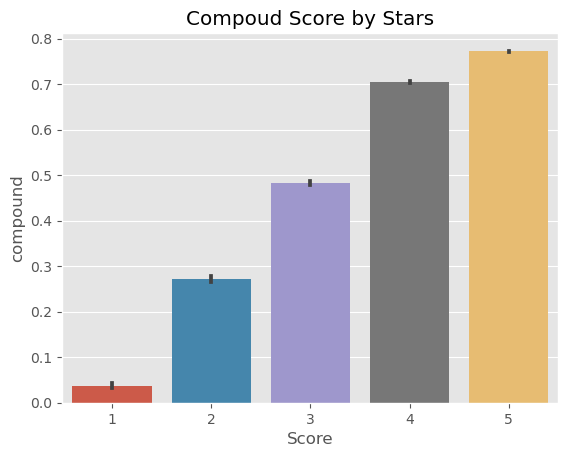

In [19]:
ax = sns.barplot(data=vaders, x='Score', y='compound');
ax.set_title('Compoud Score by Stars')
plt.show()

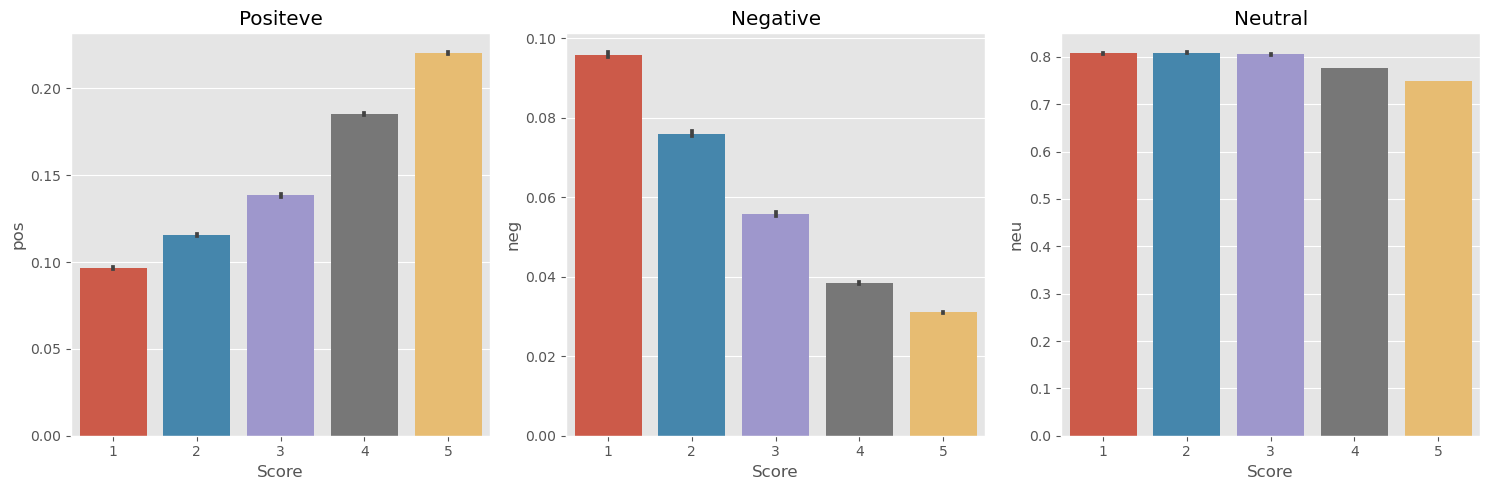

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(15,5))
sns.barplot(data=vaders, x='Score', y='pos', ax=axs[0]);
sns.barplot(data=vaders, x='Score', y='neg', ax=axs[1]);
sns.barplot(data=vaders, x='Score', y='neu', ax=axs[2]);
axs[0].set_title('Positeve')
axs[1].set_title('Negative')
axs[2].set_title('Neutral')
plt.tight_layout()

### Roberta Pretrained Model

In [18]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [19]:
# VADER results on example
print(example)
sia.polarity_scores(example)

This oatmeal is not good. Its mushy, soft, I don't like it. Quaker Oats is the way to go.


{'neg': 0.22, 'neu': 0.78, 'pos': 0.0, 'compound': -0.5448}

In [20]:
# Run Roberta Model
encoded_text = tokenizer(example, return_tensors='pt')
output = model(**encoded_text)
scores = output[0][0].detach().numpy()
scores = softmax(scores)
scores_dict = {
    'roberta_neg': scores[0],
    'roberta_neu': scores[1],
    'roberta_pos': scores[2]
}

In [21]:
scores_dict

{'roberta_neg': 0.97635514,
 'roberta_neu': 0.020687465,
 'roberta_pos': 0.0029573692}

In [22]:
def polarity_scores_roberta(example):
    encoded_text = tokenizer(example, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
        'roberta_neg': scores[0],
        'roberta_neu': scores[1],
        'roberta_pos': scores[2]
    }
    return scores_dict

In [23]:
# run polarity score on the entire dataset
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    try:
        text = row['Text']
        my_id = row['Id']
        
        vader_result = sia.polarity_scores(text)
        
        # Rename vader_result keys with "vader_" prefix
        vader_result_rename = {f"vader_{key}": value for key, value in vader_result.items()}        
        
        #Store 'both' dictionary in 'res' dictionary using 'my_id' as the key
        res[my_id] = vader_result_rename
    except RuntimeError:
        print(f'Broke for id {my_id}')


  0%|          | 0/568454 [00:00<?, ?it/s]

In [24]:
vader = pd.DataFrame(res).T
vader = vader.reset_index().rename(columns={'index': 'Id'})
df_final = vader.merge(df, how='left')

In [25]:
df_final.head()

,Id,vader_neg,vader_neu,vader_pos,vader_compound,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,0.000,0.695,0.305,0.9441,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,0.138,0.862,0.000,-0.5664,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,0.091,0.754,0.155,0.8265,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,0.000,1.000,0.000,0.0000,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,0.000,0.552,0.448,0.9468,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [26]:
df_final.query('Score == 1').sort_values('vader_pos', ascending=False)['Text'].values[0]

'Quality of product is excellent, cost is excellent and delivery is superb.  Very satisfied.'

### Using Transformers Pipeline

In [27]:
sent_pipeline =  pipeline('sentiment-analysis')

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


In [28]:
sent_pipeline('I love you')

[{'label': 'POSITIVE', 'score': 0.9998656511306763}]

In [29]:
# Define a worker function to perform sentiment analysis
def analyze_sentiment(args):
    row, sent_pipeline = args
    text = row['Text']
    my_id = row['Id']
    try:
        sentiment = sent_pipeline(text)
        return my_id, sentiment
    except RuntimeError:
        print(f'Broke for id {my_id}')
        return None

# Number of parallel processes (adjust according to your CPU cores)
num_processes = multiprocessing.cpu_count()

# Split the DataFrame into chunks for parallel processing
chunk_size = len(df) // num_processes
chunks = [df[i:i+chunk_size] for i in range(0, len(df), chunk_size)]

# Create a multiprocessing Pool
pool = multiprocessing.Pool(processes=num_processes)

# Create arguments for the sentiment analysis function
sent_pipeline = sent_pipeline  # Define your sentiment analysis pipeline function
args_list = [(row, sent_pipeline) for chunk in chunks for _, row in chunk.iterrows()]

# Initialize tqdm to track progress
progress = tqdm(total=len(args_list))

# Use multiprocessing Pool to analyze sentiment in parallel
def update_progress(result):
    progress.update()
    return result

results = pool.map(update_progress, pool.map(analyze_sentiment, args_list))
pool.close()
pool.join()

# Close tqdm progress bar
progress.close()

# Create a dictionary with the results
res = {my_id: sentiment for result in results if result is not None for my_id, sentiment in result}

# Now, res contains the sentiment analysis results for each 'Id'


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The 

  0%|          | 0/568454 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (1623 > 512). Running this sequence through the model will result in indexing errors
Token indices sequence length is longer than the specified maximum sequence length for this model (626 > 512). Running this sequence through the model will result in indexing errors


Broke for id 124363huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Broke for id 44416



Token indices sequence length is longer than the specified maximum sequence length for this model (601 > 512). Running this sequence through the model will result in indexing errors


Broke for id 106600
Broke for id 124368


Token indices sequence length is longer than the specified maximum sequence length for this model (682 > 512). Running this sequence through the model will result in indexing errors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Broke for id 53314


Token indices sequence length is longer than the specified maximum sequence length for this model (534 > 512). Running this sequence through the model will result in indexing errors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Broke for id 71081


Token indices sequence length is longer than the specified maximum sequence length for this model (544 > 512). Running this sequence through the model will result in indexing errors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Broke for id 35558


Token indices sequence length is longer than the specified maximum sequence length for this model (581 > 512). Running this sequence through the model will result in indexing errors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Broke for id 88861


Token indices sequence length is longer than the specified maximum sequence length for this model (545 > 512). Running this sequence through the model will result in indexing errors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Broke for id 133278
Broke for id 35578


Token indices sequence length is longer than the specified maximum sequence length for this model (616 > 512). Running this sequence through the model will result in indexing errors


Broke for id 8935
Broke for id 88884
Broke for id 71117
Broke for id 71120


Token indices sequence length is longer than the specified maximum sequence length for this model (1015 > 512). Running this sequence through the model will result in indexing errors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Broke for id 115523
Broke for id 115524
Broke for id 71124
Broke for id 71125
Broke for id 71126
Broke for id 115527
Broke for id 115528
Broke for id 71131
Broke for id 71132
Broke for id 71133
Broke for id 88904
Broke for id 71135


Token indices sequence length is longer than the specified maximum sequence length for this model (582 > 512). Running this sequence through the model will result in indexing errors


Broke for id 83
Broke for id 124441
Broke for id 44498
Broke for id 71144
Broke for id 115549
Broke for id 44510
Broke for id 35639
Broke for id 133328
Broke for id 71163
Broke for id 133337
Broke for id 133338
Broke for id 71173
Broke for id 133351


Token indices sequence length is longer than the specified maximum sequence length for this model (755 > 512). Running this sequence through the model will result in indexing errors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Broke for id 80087
Broke for id 106737
Broke for id 80091
Broke for id 133373


Token indices sequence length is longer than the specified maximum sequence length for this model (687 > 512). Running this sequence through the model will result in indexing errors


Broke for id 35706
Broke for id 17939
Broke for id 187
Broke for id 124545
Broke for id 53520
Broke for id 133421


Token indices sequence length is longer than the specified maximum sequence length for this model (686 > 512). Running this sequence through the model will result in indexing errors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Broke for id 97938
Broke for id 97943
Broke for id 133429
Broke for id 115679
Broke for id 97967
Broke for id 97972
Broke for id 18028
Broke for id 44663
Broke for id 44667
Broke for id 97977
Broke for id 97978
Broke for id 97979
Broke for id 97980
Broke for id 97981
Broke for id 97982


Token indices sequence length is longer than the specified maximum sequence length for this model (859 > 512). Running this sequence through the model will result in indexing errors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Broke for id 26906
Broke for id 97990
Broke for id 97991


Token indices sequence length is longer than the specified maximum sequence length for this model (576 > 512). Running this sequence through the model will result in indexing errors


Broke for id 62468
Broke for id 98011
Broke for id 71338
Broke for id 98031
Broke for id 98042
Broke for id 98043
Broke for id 89165
Broke for id 89177
Broke for id 71385
Broke for id 71389
Broke for id 53684
Broke for id 80336
Broke for id 89218
Broke for id 133584
Broke for id 18192
Broke for id 44804
Broke for id 80380
Broke for id 107071
Broke for id 80407
Broke for id 107091
Broke for id 98185
Broke for id 124838
Broke for id 18245
Broke for id 124848
Broke for id 53806
Broke for id 107125
Broke for id 529
Broke for id 36033
Broke for id 540
Broke for id 107154
Broke for id 53858
Broke for id 36082
Broke for id 71586
Broke for id 116006
Broke for id 124931
Broke for id 98273
Broke for id 98274
Broke for id 53884
Broke for id 89402
Broke for id 18343
Broke for id 89405
Broke for id 80523
Broke for id 36116
Broke for id 80533
Broke for id 124957
Broke for id 133774
Broke for id 89428
Broke for id 53925
Broke for id 133801
Broke for id 116081
Broke for id 71661
Broke for id 116083
Br

KeyboardInterrupt: 

Broke for id 139230
